## 2) Implementem duas redes neurais artificiais para o problema de classificação de dígitos escritos à mão utilizando a base de dados do MNIST, disponível em: https://www.kaggle.com/datasets/hojjatk/mnist-dataset. A primeira rede deve ser uma rede neural perceptron de múltiplas camadas clássica, e a segunda deve ser uma Rede Neural Convolucional (CNN). Compare o desempenho das duas redes analisando a curva de erro médio e a matriz de confusão.

### Imports e tratamento dos dados

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable


In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 145921160.91it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 116926345.39it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46832153.23it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23993109.28it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



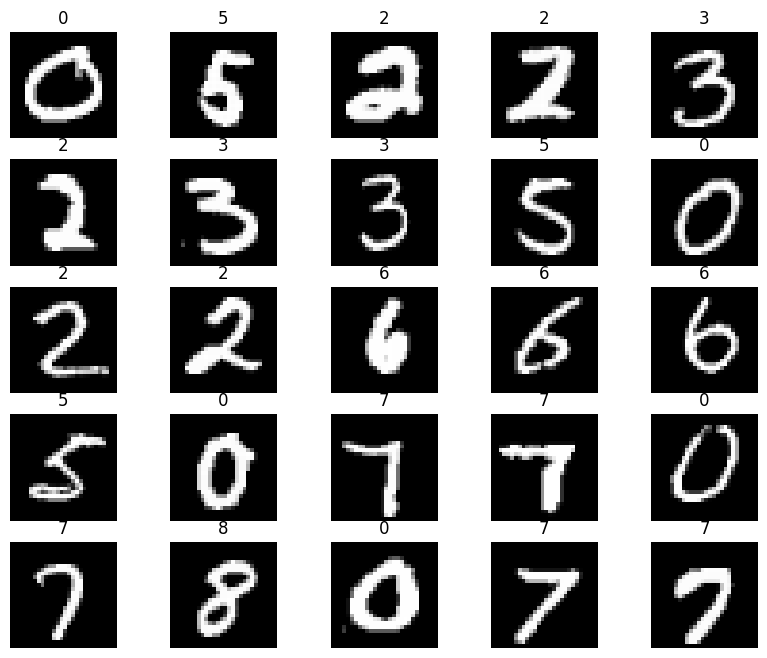

In [3]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [4]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7d3b6f6f3250>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7d3b6f6f3b50>}

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Perceptron multicamadas

In [16]:
from torch.utils.data import DataLoader, random_split
from math import floor
from torch import argmax
import torch
from torch.nn import Sequential, Linear, ReLU, LogSoftmax, Flatten

config = {'batch_size': 128,
 'beta_1': 0.986435025614692,
 'beta_2': 0.9904482393527106,
 'dense_1': 485,
 'dense_2': 176,
 'dense_3': 131,
 'dense_4': 122,
 'epochs': 19,
 'learning_rate': 0.00012885226472854095}

def split_data(data, test, validation_split=0.2, batch_size=32):
    data_length = len(data)

    validation_size = floor(validation_split * data_length)

    validation, train = random_split(
        data, [validation_size, data_length - validation_size])

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


def fit(model, train_loader, val_loader, optimizer, loss_fn, epochs, batch_size):
    history = {
        'val_loss': [],
        'val_accuracy': [],
        'loss': [],
        'accuracy': []
    }
    for epoch in range(epochs):
        train_correct = 0
        train_total = 0
        val_correct = 0
        val_total = 0
        train_loss = 0
        val_loss = 0

        for x_train, y_train in train_loader:
            optimizer.zero_grad()
            y_pred_dist = model(x_train)
            y_pred = argmax(y_pred_dist, dim=1)
            loss = loss_fn(y_pred_dist, y_train)

            train_loss += loss.item()
            train_total += len(y_train)
            train_correct += (y_pred == y_train).sum().item()
            loss.backward()
            optimizer.step()

        for x_val, y_val in val_loader:
            with torch.no_grad():
                y_pred_dist = model(x_val)
                y_pred = argmax(y_pred_dist, dim=1)
                loss = loss_fn(y_pred_dist, y_val)
                val_loss += loss.item()
                val_total += len(y_val)
                val_correct += (y_pred == y_val).sum().item()

        val_loss /= len(val_loader.dataset)/batch_size
        train_loss /= len(train_loader.dataset)/batch_size

        val_acc = val_correct/val_total
        train_acc = train_correct/train_total

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        print(f'Epoch {epoch + 1}/{epochs}: loss {train_loss}, val_loss {val_loss}, ' +
              f'accuracy {train_acc}, val_accuracy {val_acc}')

    return history


def create_model(config):
    mlp = Sequential(
        Flatten(),
        Linear(28 * 28, config["dense_1"]),
        ReLU(),
        Linear(config["dense_1"], config["dense_2"]),
        ReLU(),
        Linear(config["dense_2"], config["dense_3"]),
        ReLU(),
        Linear(config["dense_3"], config["dense_4"]),
        ReLU(),
        Linear(config["dense_4"], 10),
        LogSoftmax(dim=1)
    )
    return mlp

def create_model(config):
    mlp = Sequential(
        Flatten(),
        Linear(28 * 28, config["dense_1"]),
        ReLU(),
        Linear(config["dense_1"], config["dense_2"]),
        ReLU(),
        Linear(config["dense_2"], config["dense_3"]),
        ReLU(),
        Linear(config["dense_3"], config["dense_4"]),
        ReLU(),
        Linear(config["dense_4"], 10),
        LogSoftmax(dim=1)
    )
    return mlp


def evaluate(model, test_loader):
    y_test_all = []
    y_pred_all = []
    total = 0
    correct = 0

    with torch.no_grad():
        for x_test, y_test in test_loader:
            outputs = model(x_test)
            predicted = argmax(outputs, dim=1)
            y_pred_all.extend(predicted.numpy())
            y_test_all.extend(y_test.numpy())
            total += len(y_test)
            correct += (predicted == y_test).sum().item()

    return y_test_all, y_pred_all

In [7]:
data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test =  datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

train_loader, val_loader, test_loader = split_data(data, test, batch_size=config["batch_size"])


In [8]:
from torch.optim import Adam
from torch.nn import NLLLoss

mlp = create_model(config)

loss = NLLLoss()
optimizer = Adam(mlp.parameters(), lr=config["learning_rate"], betas=(config["beta_1"], config["beta_2"]))

In [9]:
history = fit(mlp, train_loader, val_loader, optimizer, loss, config["epochs"], config["batch_size"])

Epoch 1/19: loss 1.1852244897683462, val_loss 0.5307263387044271, accuracy 0.6364166666666666, val_accuracy 0.8294166666666667
Epoch 2/19: loss 0.4050571211576462, val_loss 0.3318894842465719, accuracy 0.87775, val_accuracy 0.9020833333333333
Epoch 3/19: loss 0.30649967602888745, val_loss 0.2794069871902466, accuracy 0.9112708333333334, val_accuracy 0.92175
Epoch 4/19: loss 0.25625720296303434, val_loss 0.23402338576316833, accuracy 0.9251666666666667, val_accuracy 0.93625
Epoch 5/19: loss 0.21838295195500057, val_loss 0.2059176948070526, accuracy 0.9364375, val_accuracy 0.9420833333333334
Epoch 6/19: loss 0.1883214175303777, val_loss 0.1872533700466156, accuracy 0.9448541666666667, val_accuracy 0.9455833333333333
Epoch 7/19: loss 0.1660738592048486, val_loss 0.1655461746851603, accuracy 0.9515833333333333, val_accuracy 0.9529166666666666
Epoch 8/19: loss 0.1458491071164608, val_loss 0.16109148263931275, accuracy 0.9572916666666667, val_accuracy 0.95425
Epoch 9/19: loss 0.1292201378544

In [37]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def plot_training(acc, val_acc, loss, val_loss):
    plt.subplots(figsize=(12, 3))

    plt.subplot(1, 2, 1)
    plt.plot(
        acc,
        label='Training Accuracy'
    )
    plt.plot(
        val_acc,
        label='Validation Accuracy'
    )
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(
        loss,
        label='Training Loss',
        color='teal'
    )
    plt.plot(
        val_loss,
        label='Validation Loss',
        color='brown'
    )
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()


def show_confusion_matrix(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    matrix_display = ConfusionMatrixDisplay(matrix)
    matrix_display.plot(cmap='Blues')

<ipython-input-17-1d34bddb12c0>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


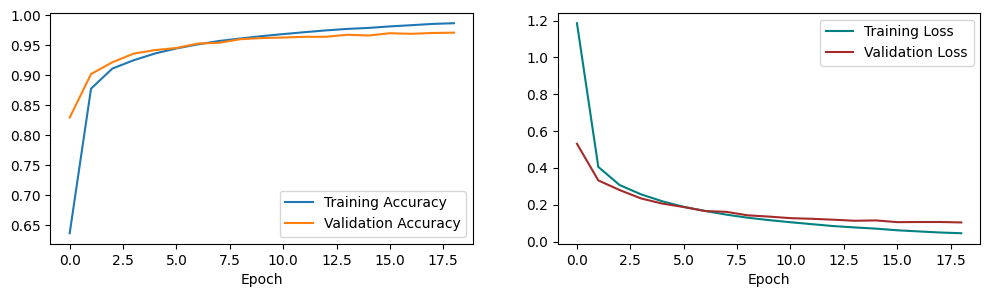

In [18]:
plot_training(
    history['accuracy'],
    history['val_accuracy'],
    history['loss'],
    history['val_loss']
)

In [19]:
from sklearn.metrics import classification_report

y_test_all, y_pred_all = evaluate(mlp, test_loader)

report = classification_report(y_test_all, y_pred_all, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9719    0.9888    0.9803       980
           1     0.9894    0.9885    0.9890      1135
           2     0.9776    0.9748    0.9762      1032
           3     0.9510    0.9802    0.9654      1010
           4     0.9785    0.9725    0.9755       982
           5     0.9762    0.9641    0.9701       892
           6     0.9770    0.9770    0.9770       958
           7     0.9801    0.9591    0.9695      1028
           8     0.9488    0.9702    0.9594       974
           9     0.9756    0.9495    0.9623      1009

    accuracy                         0.9727     10000
   macro avg     0.9726    0.9725    0.9725     10000
weighted avg     0.9729    0.9727    0.9727     10000



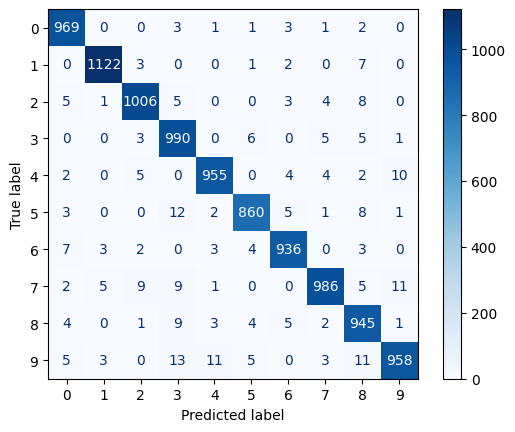

In [38]:
show_confusion_matrix(y_test_all, y_pred_all)

## CNN

In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output



In [27]:
loss_func = nn.CrossEntropyLoss()

In [28]:
cnn = CNN()

In [29]:
optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.01)

In [31]:
# def test():
#     list_acc = []
#     cnn.eval()
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         for images, labels in loaders['test']:
#             test_output, last_layer = cnn(images)
#             pred_y = torch.max(test_output, 1)[1].data.squeeze()
#             accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
#             list_acc.append([pred_y, accuracy])
#     print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

# test()

In [35]:
history = fit(cnn, train_loader, val_loader, optimizer, loss_func, config["epochs"], config["batch_size"])

Epoch 1/19: loss 0.19352101143201192, val_loss 0.08117890742421151, accuracy 0.93675, val_accuracy 0.9743333333333334
Epoch 2/19: loss 0.05918418328774472, val_loss 0.08791970594724019, accuracy 0.9807083333333333, val_accuracy 0.9741666666666666
Epoch 3/19: loss 0.04508472628581027, val_loss 0.05671107965707779, accuracy 0.9854375, val_accuracy 0.9835833333333334
Epoch 4/19: loss 0.03948849853066107, val_loss 0.061353430972745024, accuracy 0.9873541666666666, val_accuracy 0.9833333333333333
Epoch 5/19: loss 0.03645446802504981, val_loss 0.07019657700757186, accuracy 0.9886458333333333, val_accuracy 0.9815833333333334
Epoch 6/19: loss 0.03916864025771308, val_loss 0.07747588147222996, accuracy 0.9876875, val_accuracy 0.9803333333333333
Epoch 7/19: loss 0.03876504142008101, val_loss 0.057460738830268386, accuracy 0.9882916666666667, val_accuracy 0.9846666666666667
Epoch 8/19: loss 0.032900618224870413, val_loss 0.06467866218586762, accuracy 0.9895625, val_accuracy 0.9848333333333333
Epo

<ipython-input-17-1d34bddb12c0>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


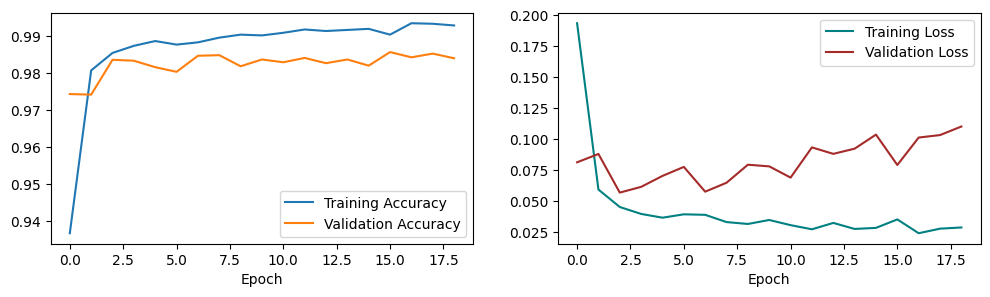

In [36]:
plot_training(
    history['accuracy'],
    history['val_accuracy'],
    history['loss'],
    history['val_loss']
)

In [39]:
y_test_all, y_pred_all = evaluate(mlp, test_loader)
report = classification_report(y_test_all, y_pred_all, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9719    0.9888    0.9803       980
           1     0.9894    0.9885    0.9890      1135
           2     0.9776    0.9748    0.9762      1032
           3     0.9510    0.9802    0.9654      1010
           4     0.9785    0.9725    0.9755       982
           5     0.9762    0.9641    0.9701       892
           6     0.9770    0.9770    0.9770       958
           7     0.9801    0.9591    0.9695      1028
           8     0.9488    0.9702    0.9594       974
           9     0.9756    0.9495    0.9623      1009

    accuracy                         0.9727     10000
   macro avg     0.9726    0.9725    0.9725     10000
weighted avg     0.9729    0.9727    0.9727     10000



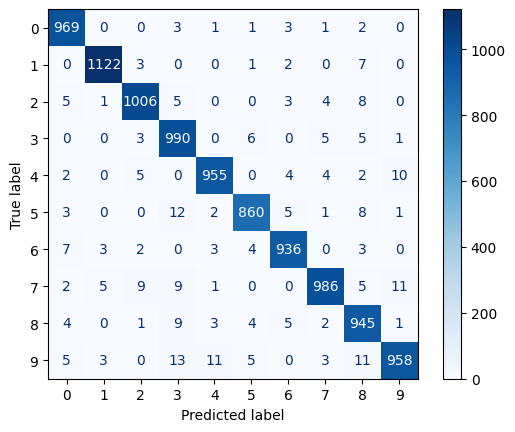

In [40]:
show_confusion_matrix(y_test_all, y_pred_all)

In [41]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [42]:
actual_number = lbls[:10].numpy()
actual_number

array([2, 1, 2, 4, 1, 9, 0, 9, 9, 4])

In [46]:
test_output = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
pred_y

array([2, 1, 2, 4, 1, 9, 0, 9, 9, 4])

In [47]:
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [2 1 2 4 1 9 0 9 9 4]
Actual number: [2 1 2 4 1 9 0 9 9 4]
